In [1]:
from tucan.io import graph_from_file
from tucan.canonicalization import partition_molecule_by_attribute, refine_partitions, get_refinement_tree_node_children, get_discrete_partitionings, get_canonical_molecule
from tucan.visualization import draw_molecules
from tucan.graph_attributes import PARTITION, INVARIANT_CODE
import networkx as nx

In [2]:
m_name = "Petersen_graph"
m = graph_from_file(f"../tests/molfiles/{m_name}/{m_name}.mol")
m_partitioned_by_invariants = partition_molecule_by_attribute(m, INVARIANT_CODE)

At this point, all node attributes that are included in `INVARIANT_CODE` are encoded in the node's `PARTITION` attribute.
That is, in the subsequent canonicalization steps, all node attributes other than `PARTITION` can be disregarded.

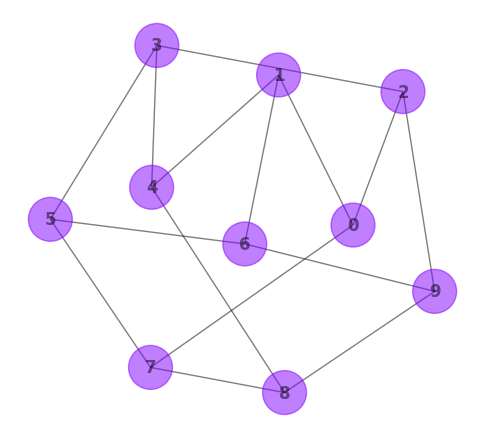

In [3]:
m_refined = list(refine_partitions(m_partitioned_by_invariants))[-1]
draw_molecules([m_refined], [""], highlight=PARTITION)

Build refinement tree with BFS.
See https://doi.org/10.1016/j.jsc.2013.09.003 and https://pallini.di.uniroma1.it/SearchTree.html.

Side note: Both atoms and vertices on the refinement tree are called "nodes" atm.
Call node on the refinement tree "refinement-tree-node" to avoid confusion.

Once the partitions are maximally refined, we need to artificially refine them until they're discrete.
In order to artificially refine the partitions, we need to split them. See `get_refinement_tree_node_children`.
Below we show how to generate the nodes for one level of the refinement tree.

10


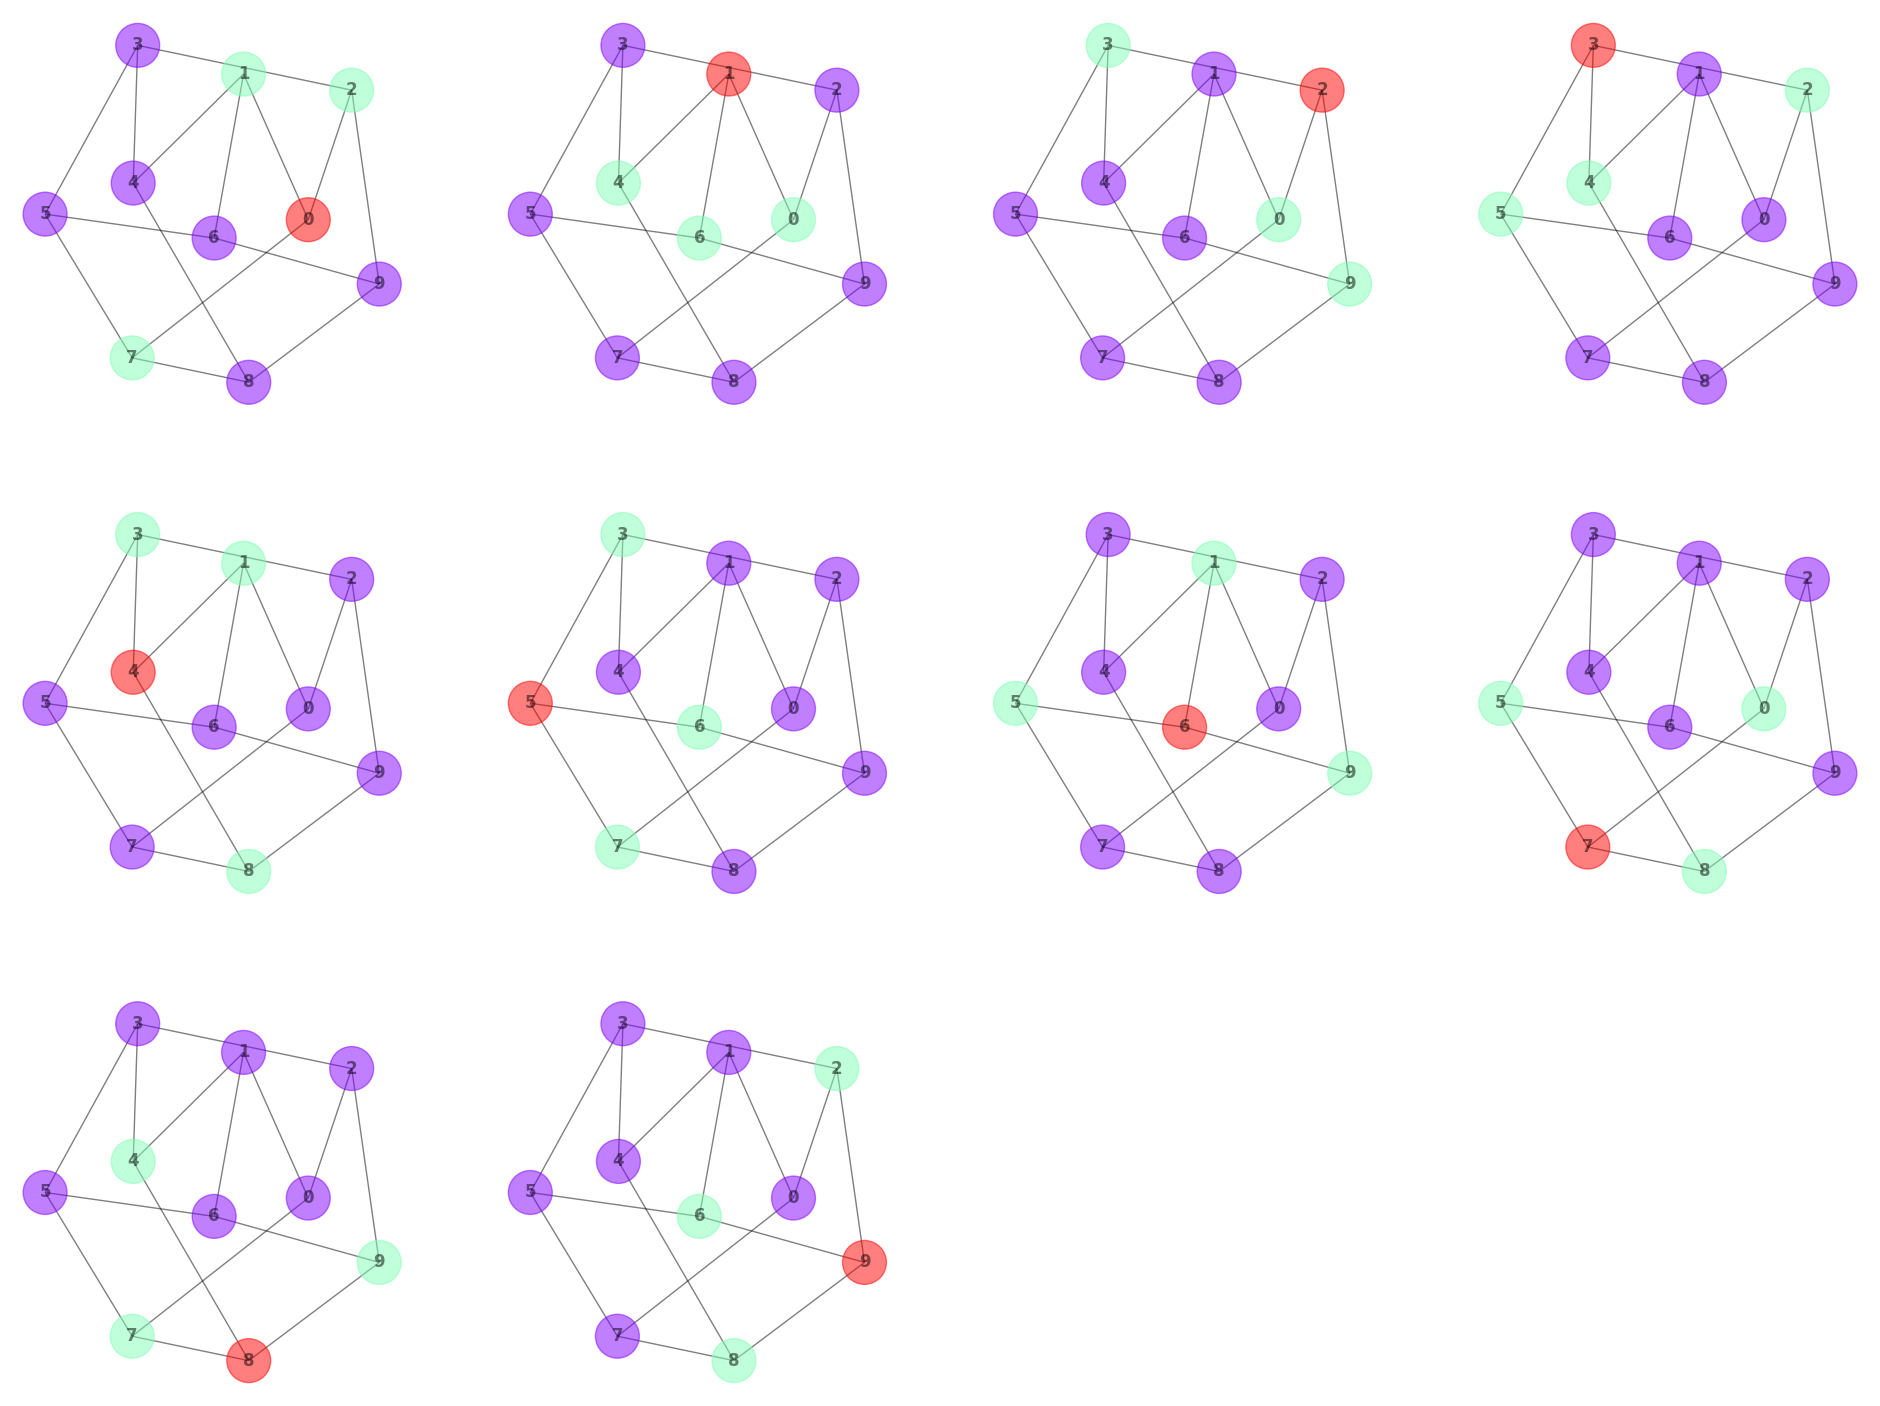

In [4]:
children = list(get_refinement_tree_node_children(m_refined))
print(len(children))
draw_molecules(children, ["" for _ in range(len(children))], highlight=PARTITION)

Let's build up the entire refinement-tree. The leaves (i.e., nodes at the final level) are the discrete partitionings.
Note: Distinguish between "partitioning" (set of partitions of one graph) and "partition".

The leaves of the refinement-tree are the 120 automorphisms of the [Petersen graph](https://en.wikipedia.org/wiki/Petersen_graph). Also see https://pallini.di.uniroma1.it/SearchTree.html.

120


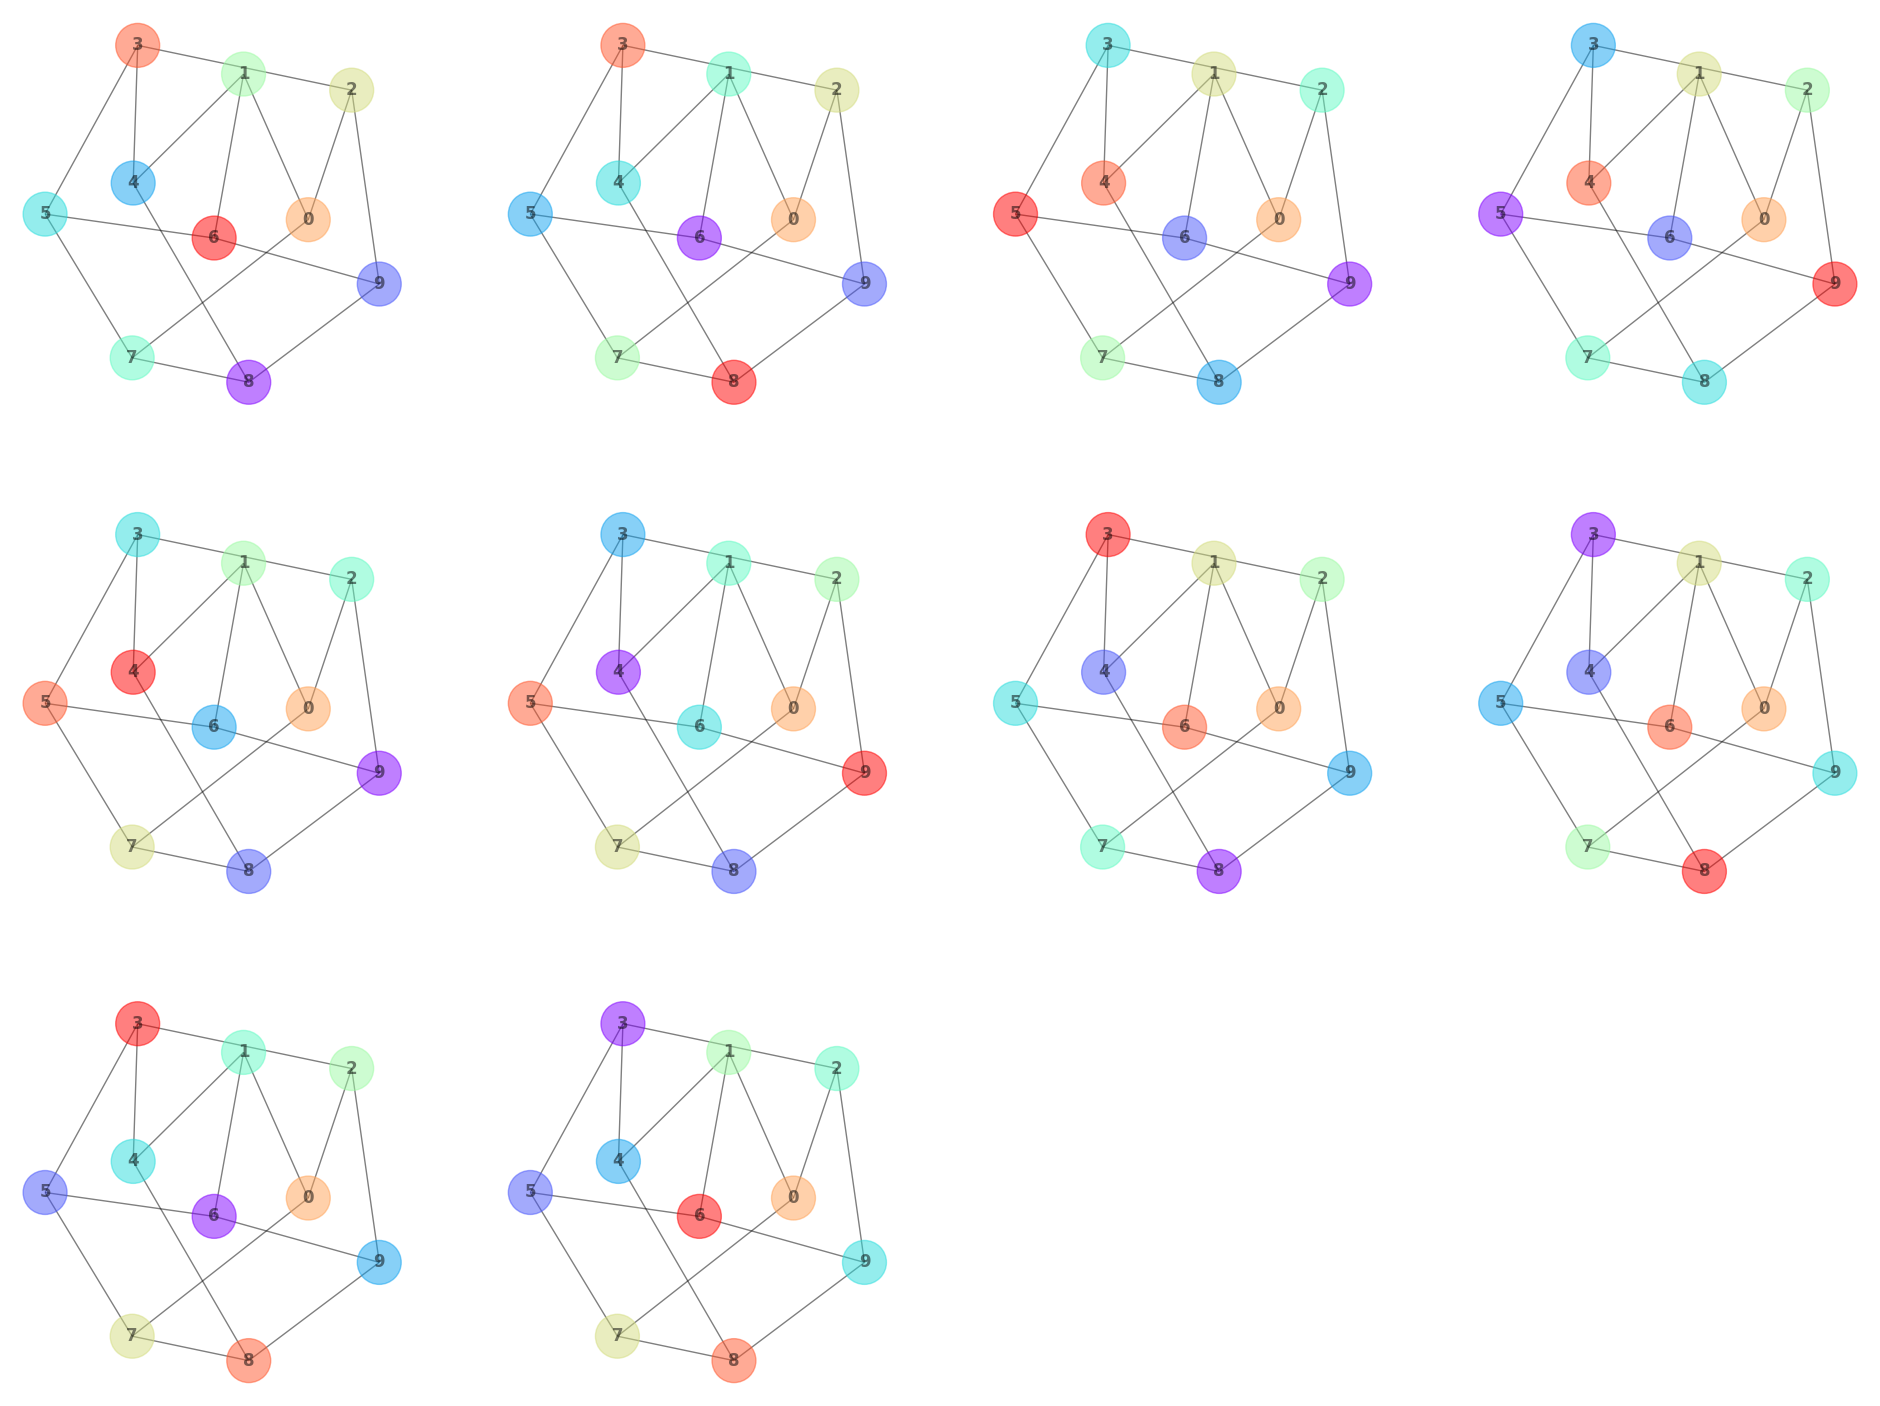

In [5]:
discrete_partitionings = list(get_discrete_partitionings(m_refined))
print(len(discrete_partitionings))
n_partitionings = len(discrete_partitionings)
n_plots = min(n_partitionings, 10)
draw_molecules(discrete_partitionings[:n_plots], ["" for _ in range(n_plots)], highlight=PARTITION)

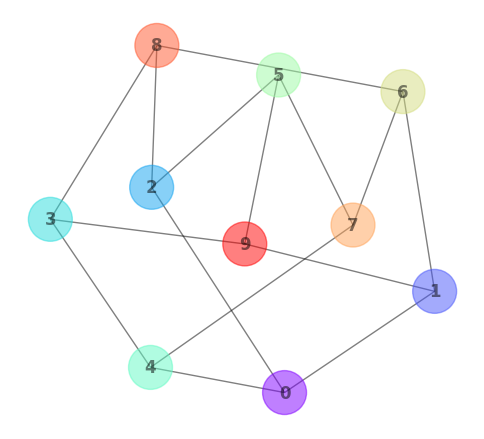

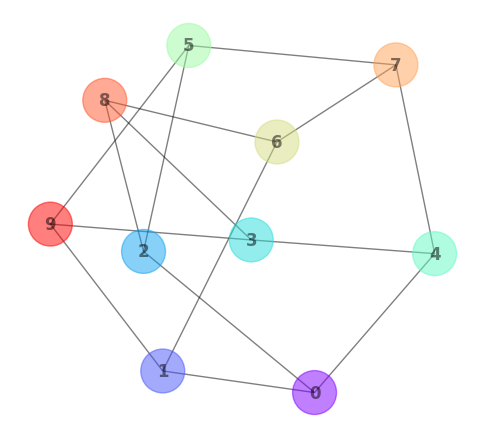

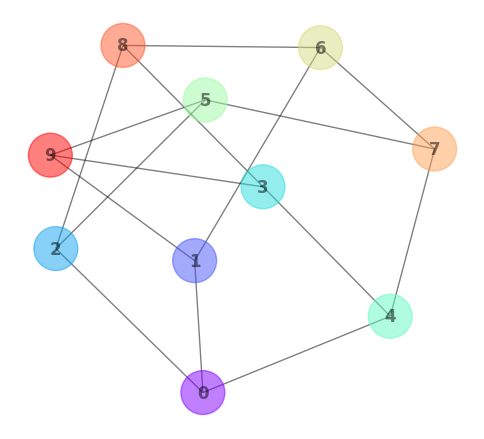

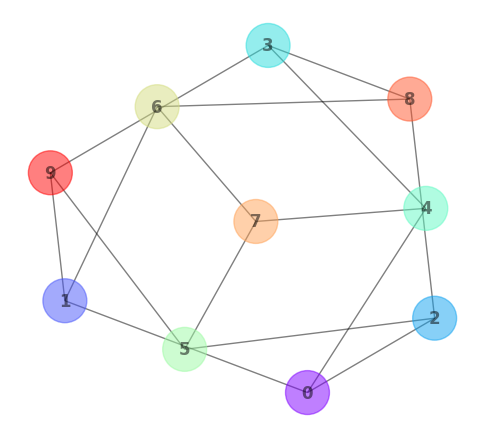

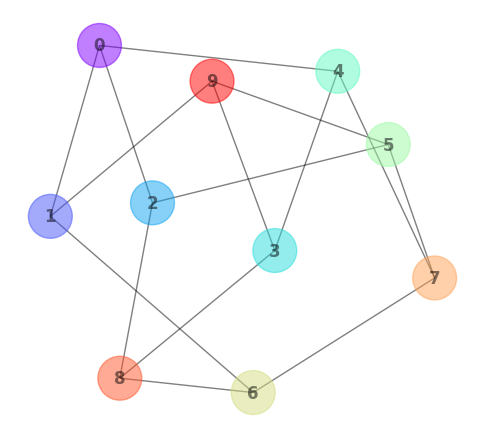

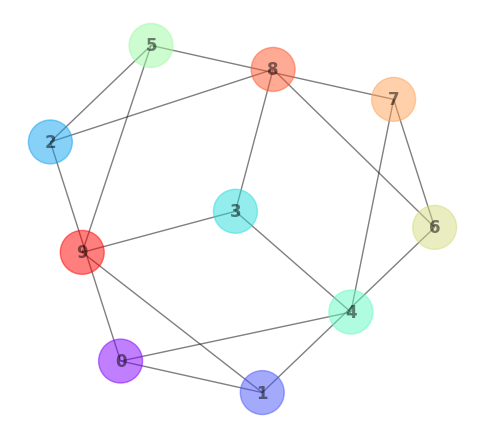

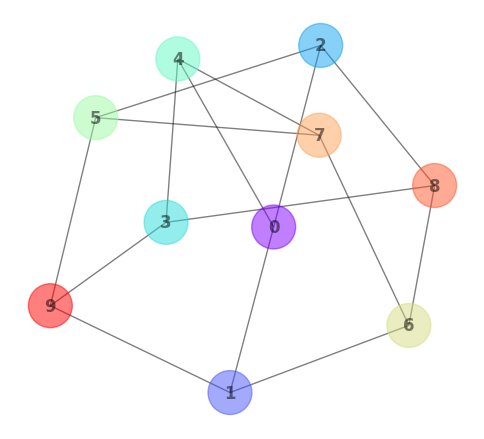

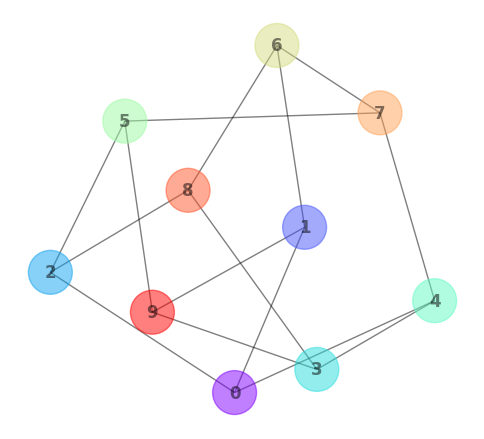

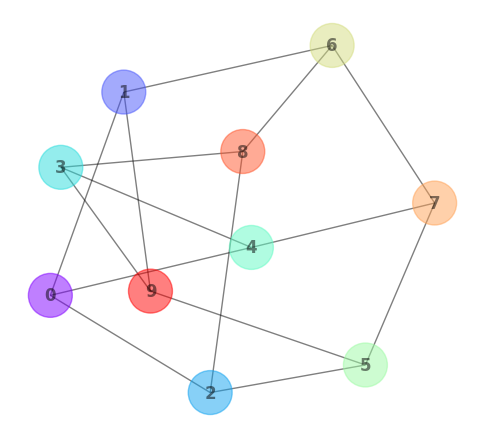

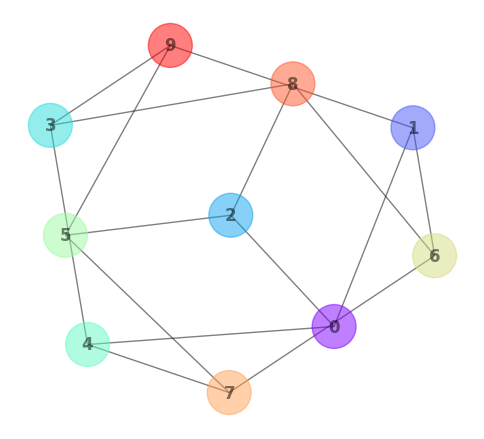

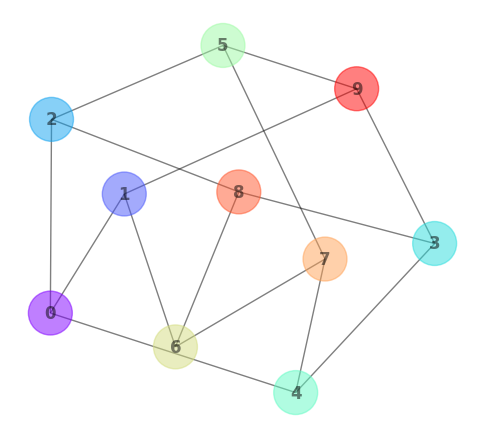

In [6]:
import random
from tucan.graph_utils import permute_molecule
from tucan.serialization import serialize_molecule

def canonicalize_molecule(m: nx.Graph) -> nx.Graph:
    m_partitioned_by_invariant_code = partition_molecule_by_attribute(m, INVARIANT_CODE)
    m_refined = list(refine_partitions(m_partitioned_by_invariant_code))[-1]
    ms_discrete_partitionings = list(get_discrete_partitionings(m_refined))
    canonical_molecule = get_canonical_molecule(ms_discrete_partitionings)
    draw_molecules([canonical_molecule], [""], highlight=PARTITION)
    
    return canonical_molecule

    
def permutation_invariance(m: nx.Graph, n_runs=10, random_seed=random.random()):
    """Tests that different permutations of the same molecular graph yield one
    and the same TUCAN string."""
    m_canon = canonicalize_molecule(m)
    m_serialized = serialize_molecule(m_canon)
    random.seed(random_seed)
    for _ in range(n_runs):
        permutation_seed = random.random()
        m_permu = permute_molecule(m, random_seed=permutation_seed)
        m_permu_canon = canonicalize_molecule(m_permu)
        m_permu_serialized = serialize_molecule(m_permu_canon)
        
        assert m_serialized == m_permu_serialized
        
permutation_invariance(m, random_seed=42)
        